# Xception Baseline Model for Starter in Keras
## Severstal: Steel Defect Detection

This kernel is based on [EDA and OpenCV Starter](https://www.kaggle.com/paulorzp/eda-and-opencv-starter) and [Keras](https://www.kaggle.com/ateplyuk/keras).

__Xception Model__ using __bce_dice_loss__ is applied.

## Contents
1. Introduction <br/>
2. Xception Model in Keras <br/>
3. Training <br/>
4. Prediction and Plot Result <br/>
5. Submission <br/>

## 1. Introduction

![](https://raw.githubusercontent.com/seriousmac/img_link/master/kg/01.jpeg)

> In this competition, you’ll help engineers improve the algorithm by localizing and classifying surface defects on a steel sheet.

### Xception Model

- Xception V1 model, with weights pre-trained on ImageNet.
- On ImageNet, this model gets to a top-1 validation accuracy of 0.790 and a top-5 validation accuracy of 0.945.
![](https://raw.githubusercontent.com/seriousmac/img_link/master/kg/02.PNG)
- ref: [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)

### View Defects and Classes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm_notebook
print(os.listdir("../input"))

['keras-pretrained-models', 'severstal-steel-defect-detection']


Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
train['defect'] = train['EncodedPixels'].notnull()
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train = train[['ImageId','ClassId','defect','EncodedPixels']]
train = train[train.defect]

In [3]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

def rle2mask_eda(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [4]:
train = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
train['defect'] = train['EncodedPixels'].notnull()
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train = train[['ImageId','ClassId','defect','EncodedPixels']]
train = train[train.defect]
mask2rle(rle2mask_eda(train['EncodedPixels'].iloc[1]))==train['EncodedPixels'].iloc[1]

False

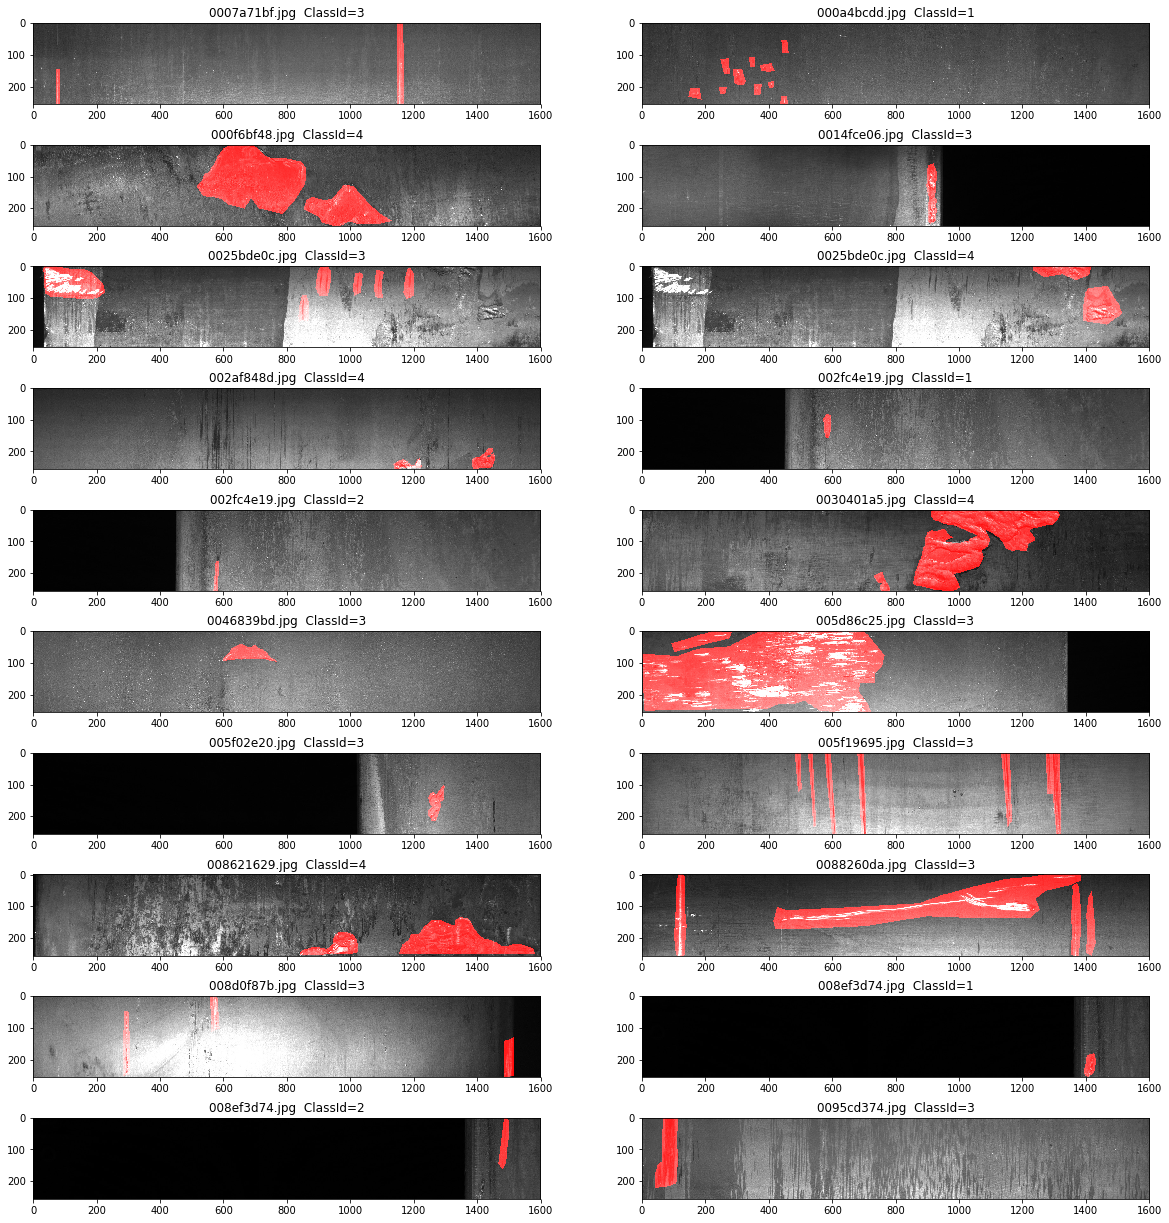

In [5]:
# ref: https://www.kaggle.com/paulorzp/eda-and-opencv-starter
columns = 2
rows = 10
fig = plt.figure(figsize=(20,columns*rows+2))
for i in range(1,columns*rows+1):
    fn = train['ImageId'].iloc[i]
    c = train['ClassId'].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn+"  ClassId="+c)
    img = cv2.imread( '../input/severstal-steel-defect-detection/train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask_eda(train['EncodedPixels'].iloc[i])
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

## 2. Xception Model in Keras

In [6]:
df_train = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
df_train = df_train[df_train['EncodedPixels'].notnull()].reset_index(drop=True)

In [7]:
IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 30
PATIENCE = 7

In [8]:
#ref: https://www.kaggle.com/ateplyuk/keras
def keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread( '../input/severstal-steel-defect-detection/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float64')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.8), 'float64')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [10]:
#ref: https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.8], tf.float64)

In [11]:
def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss', 
        patience=patient, 
        mode='max', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='max')
    return [ES, RR]

In [12]:
base_model = Xception(weights=None, input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False)
base_model.load_weights('../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

base_out = base_model.output
up1 = UpSampling2D(32, interpolation='bilinear')(base_out)
conv1 = Conv2D(1, (1, 1))(up1)
conv1 = Activation('sigmoid')(conv1)
#bn1 = BatchNormalization()(conv1)
# re2 = LeakyReLU(0.2)(bn1)
# up2 = UpSampling2D(16, interpolation='bilinear')(re2)
# conv2 = Conv2D(1, (1, 1))(up2)
# conv2 = Activation('sigmoid')(conv2)

model = Model(base_model.input, conv1)
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[iou_metric])

## 4. Training

In [13]:
history = model.fit_generator(keras_generator(BATCH_SIZE),
                              steps_per_epoch=len(df_train.index)/EPOCHS,                    
                              epochs=EPOCHS,                    
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
)

Epoch 1/30
237/236 [==============================] - 73s 308ms/step - loss: 0.3869 - iou_metric: 0.1592
Epoch 2/30
237/236 [==============================] - 60s 253ms/step - loss: 0.2818 - iou_metric: 0.1846
Epoch 3/30
237/236 [==============================] - 60s 251ms/step - loss: 0.2797 - iou_metric: 0.1871
Epoch 4/30
237/236 [==============================] - 60s 252ms/step - loss: 0.2784 - iou_metric: 0.1897
Epoch 5/30
237/236 [==============================] - 60s 253ms/step - loss: 0.2778 - iou_metric: 0.1922

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
237/236 [==============================] - 59s 251ms/step - loss: 0.2771 - iou_metric: 0.2000
Epoch 7/30
237/236 [==============================] - 59s 251ms/step - loss: 0.2769 - iou_metric: 0.2000
Epoch 8/30
237/236 [==============================] - 60s 251ms/step - loss: 0.2768 - iou_metric: 0.1992
Epoch 00008: early stopping


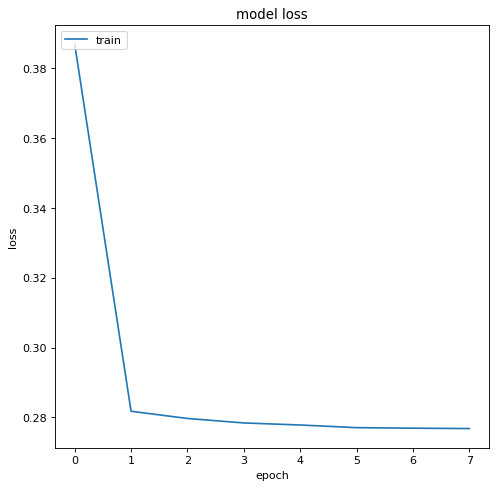

In [14]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss']) 
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper left')  
plt.show()

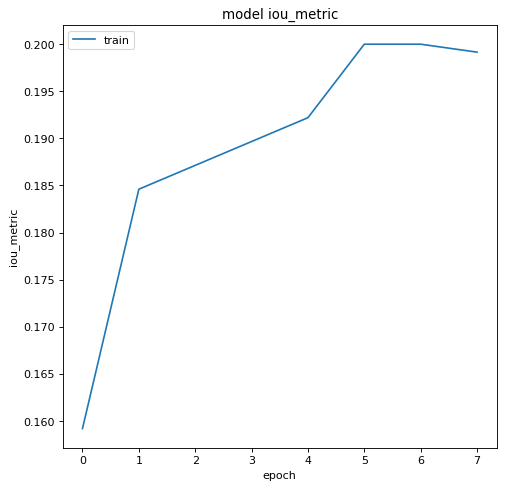

In [15]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['iou_metric']) 
plt.title('model iou_metric')  
plt.ylabel('iou_metric')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper left')  
plt.show()

## 4. Prediction & Plot Prediction Result

In [16]:
%%time
test_img = []
testfiles=os.listdir("../input/severstal-steel-defect-detection/test_images/")
for fn in tqdm_notebook(testfiles):
        img = cv2.imread( '../input/severstal-steel-defect-detection/test_images/'+fn )
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))       
        test_img.append(img)


CPU times: user 8.36 s, sys: 644 ms, total: 9 s
Wall time: 12.4 s


In [17]:
%%time
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    np.asarray(test_img),
    batch_size=BATCH_SIZE
)

testfiles=os.listdir("../input/severstal-steel-defect-detection/test_images/")
nb_samples = len(testfiles)
predict = model.predict_generator(test_generator, steps = nb_samples/BATCH_SIZE)

CPU times: user 11.5 s, sys: 22 s, total: 33.5 s
Wall time: 29.4 s


In [18]:
%%time
pred_rle = []
for img in predict:      
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    #tmp[tmp<np.mean(img)] = 0
    tmp[tmp<0.8] = 0
    tmp[tmp>0] = 1
    pred_rle.append(mask2rle(tmp))

CPU times: user 19min 32s, sys: 0 ns, total: 19min 32s
Wall time: 19min 32s


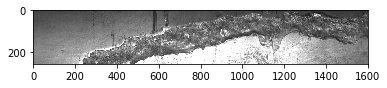

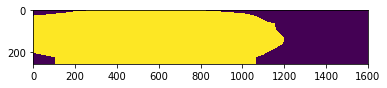

In [19]:
img_t = cv2.imread( '../input/severstal-steel-defect-detection/test_images/'+ testfiles[4])
plt.imshow(img_t)
plt.show()

mask_t = rle2mask(pred_rle[4], img.shape)
plt.imshow(mask_t)
plt.show()

## 5. Submission

In [20]:
pred_rle_4 = []
for _ in pred_rle:
    pred_rle_4.extend([_, _, _, _])    
len(pred_rle_4)

7204

In [21]:
sub = pd.read_csv( '../input/severstal-steel-defect-detection/sample_submission.csv' )
sub['EncodedPixels'] = pred_rle_4
sub.to_csv('submission.csv', index=False)
sub.head(10)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,192064 1 192320 1 192576 2 192831 4 193087 5 1...
5,006f39c41.jpg_2,192064 1 192320 1 192576 2 192831 4 193087 5 1...
6,006f39c41.jpg_3,192064 1 192320 1 192576 2 192831 4 193087 5 1...
7,006f39c41.jpg_4,192064 1 192320 1 192576 2 192831 4 193087 5 1...
8,00b7fb703.jpg_1,28 175 284 175 540 175 796 175 1052 176 1308 1...
9,00b7fb703.jpg_2,28 175 284 175 540 175 796 175 1052 176 1308 1...
